In [5]:
using Images
using Statistics
using PythonPlot
using DSP
using StatsBase
using VectorizedStatistics
using ImageMorphology
mpl = PythonPlot.pyimport("matplotlib")
mpl.rcParams["svg.fonttype"] = "none"

"none"

In [10]:
function mask_site(file, threshold; n_sites=1)
    img = load(file)
    im_array = Float64.(img) * 65535 # concert to 16bit
    # Don't do frame averaging. Was found not neccessary for images used. 
    # Use stack standard dev projection to find polarity patch(es)
    img_std = std(im_array, dims=(3))[:,:,1]
    max_bin = 0
    bin = img_std .> maximum(img_std)*threshold
    bin = dilate(bin, r=1)
    bin_lab = label_components(bin)
    masks = zeros(size(im_array)[1], size(im_array)[2], size(im_array)[3], n_sites)
    for i in range(1,n_sites)
        bin = bin .- max_bin         
        max_loc = findmax(bin.*img_std)[2]          # mask the image. find the max. get the coords.
        max_lab = bin_lab[max_loc]                  # get label in labeled mask from coords
        max_bin = bin_lab .== max_lab               # Make binary mask only around correct component
        im_masked = im_array .* max_bin 
        masks[:,:,:,i] = im_masked
    end
    return masks
end

mask_site (generic function with 1 method)

Loading: 100%|███████████████████████████████████████████| Time: 0:00:01


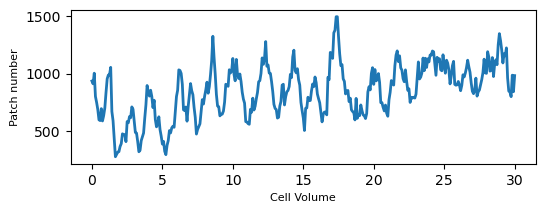

In [3]:
file = "../movies-Pak1-GFP/2024_07_08-PolProbeMovies/1patch/movie2-cell9.tif"
patch = mask_site(file, 0.5)
t = range(0,60/5*30)*(5/60) # Convert from 1 frame every 5 sec, to minutes

fig, ax = subplots(figsize=(6,2))
ax.plot(t, maximum(patch, dims=(1,2))[1,1,:], linewidth=2, color="C00")
ax.set_ylabel("Patch number", fontsize=8)
ax.set_xlabel("Cell Volume", fontsize=8)
display(gcf())

In [17]:
function crop_time(signal, frames, thresh)
    #signal = signal .- minimum(signal)
    start = Integer(findall(signal .> (maximum(signal))*thresh)[1])
    println(start)
    if start + frames < length(signal)
        crop_signal = signal[start:start+Integer(frames)]
        return crop_signal
    else 
        print(".")
        crop_signal = signal[end-Integer(frames):end]
        return crop_signal
    end
    print(start:start+Integer(frames))
end

crop_time (generic function with 1 method)

In [23]:
file = "../movies-Pak1-GFP/2024_07_08-PolProbeMovies/1patch/movie2-cell9.tif"
patch = mask_site(file, 0.5)
max_patch = maximum(patch, dims=(1,2))[1,1,:]
crop_max = crop_time(max_patch, 15*(60/5), 0.5)
t = range(1,length(crop_max))*(5/60) # Convert from 1 frame every 5 sec, to minutes

# fig, ax = subplots(figsize=(5,1))
# ax.plot(t, crop_max, linewidth=2, color="C0")
# ax.set_ylabel("Fluoresence", fontsize=8)
# ax.set_xlabel("Time (minutes)", fontsize=8)
# ax.tick_params(labelsize=8)

#savefig("../figures/trace1.svg")
#display(gcf())

1


0.08333333333333333:0.08333333333333333:15.083333333333334

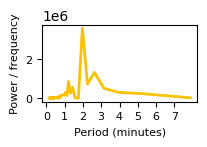

In [147]:
file = "../movies-Pak1-GFP/2024_07_08-PolProbeMovies/1patch/movie2-cell9.tif"
patch = mask_site(file, 0.5)
max_patch = maximum(patch, dims=(1,2))[1,1,:]
crop_max = crop_time(max_patch, 15*(60/5), 0.5)
pdg_crop_max = DSP.Periodograms.periodogram(crop_max)
frequencies = pdg_crop_max.freq

fig, ax = subplots(figsize=(2,1))
ax.plot(1 ./ frequencies[3:end] .* (5/60), pdg_crop_max.power[3:end], color="xkcd:goldenrod", linewidth=2)
ax.set_ylabel("Power / frequency", fontsize=8)
ax.set_xlabel("Period (minutes)", fontsize=8)
ax.tick_params(labelsize=8)
ax.set_xticks([0,1,2,3,4,5,6,7])

savefig("../figures/pdg1.svg")
display(gcf())


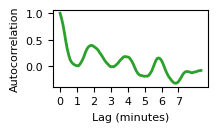

In [148]:
file = "../movies-Pak1-GFP/2024_07_08-PolProbeMovies/1patch/movie2-cell9.tif"
patch = mask_site(file, 0.5)
max_patch = maximum(patch, dims=(1,2))[1,1,:]
crop_max = crop_time(max_patch, 15*(60/5), 0.4)
ac = crosscor(crop_max, crop_max, 0:100)
t_cor = range(0,100)*(5/60)

fig, ax = subplots(figsize=(2,1))
ax.plot(t_cor, ac, color="C02", linewidth=2)
ax.set_ylabel("Autocorrelation", fontsize=8)
ax.set_xlabel("Lag (minutes)", fontsize=8)
ax.tick_params(labelsize=8)
ax.set_xticks([0,1,2,3,4,5,6,7])

#savefig("../figures/ac1.svg")
display(gcf())

In [130]:
dir = "../movies-Pak1-GFP/2024_07_08-PolProbeMovies/1patch/"
wt_files = readdir(dir)
n=0

t_cor = range(0,100)*(5/60)
peaks_ac = zeros(length(wt_files))
all_cor = zeros(91, ((length(wt_files))))

cov_threshold = 0.5

for f in wt_files
    n+=1
    patches = mask_site("$dir$f", cov_threshold, n_sites=1)
    patch1 = patches[:,:,:,1]
    max_patch1 = maximum(patch1, dims=(1,2))[1,1,:]
    crop1 = crop_time(max_patch1, 15*(60/5), 0.5)
    cell = replace(f,".tif" => "")

    fig, ax = subplots(figsize=(2.5,0.5))
    ax.plot(crop1, linewidth=2, color="C0")
    ax.tick_params(left = false, right = false , labelleft = false, labelbottom = false, bottom = false) 
    savefig("../figures/naked_traces/$(cell).svg", transparent=true)

    #ac
    ac = crosscor(crop1, crop1, 0:90)
    all_cor[:,n] = ac
    mac = findlocalmaxima(ac, window=(3,), edges=false)
    if length(mac) < 1
        continue
    else
        mac = mac[1]
        peaks_ac[n] = mac[1] * (5/60)
    end
end

..........

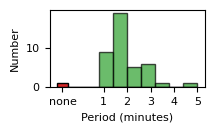

1.9085365853658536

In [125]:
peaks = filter(x -> x>0.0 && x<5,peaks_ac)
nonpeaks = filter(x -> x==0.0 || x>5,peaks_ac) .- 1

fig, ax = subplots(figsize=(2,1))
ax.hist(peaks, color="C02", alpha=0.7, bins=-1:0.6:5, edgecolor="black")
ax.hist(nonpeaks, color="C03", bins=-1:0.5:5, edgecolor="black")
ax.set_ylabel("Number", fontsize=8)
ax.set_xlabel("Period (minutes)", fontsize=8)
ax.tick_params(labelsize=8)
ax.set_xticks([-0.75,1,2,3,4,5], ["none",1,2,3,4,5])
#ax.vlines(mean(peaks), 0, 12, color="black", linestyle="--")
print(mean(peaks))
savefig("../figures/hist1.svg")
display(gcf())

..........

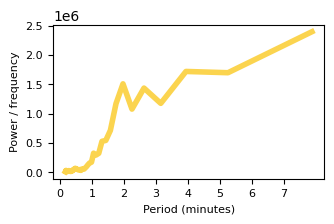

In [142]:
dir = "../movies-Pak1-GFP/2024_07_08-PolProbeMovies/1patch/"
wt_files = readdir(dir)
# plot(ylabel="Power spectral density", xlabel="Period (minutes)",
#     legend=:bottomright, size=(600,400))
t = range(0,60/5*30)*(5/60) # Convert from 1 frame every 5 sec, to minutes
max_powers = zeros(95)
n=0
frequencies = 0

fig, ax = subplots(figsize=(3.5,2))

for f in wt_files
    mask = mask_site("$dir$f", 0.5)
    max_patch = maximum(mask, dims=(1,2))[1,1,:]
    crop_max = crop_time(max_patch, 15*(60/5), 0.5)
    pdg_max = DSP.Periodograms.periodogram(crop_max)
    max_powers = max_powers .+ pdg_max.power
    frequencies = pdg_max.freq
    n+=1
    #ax.plot(1 ./ frequencies[3:end] .* (5/60), pdg_max.power[3:end], alpha=0.2)
end


ax.plot(1 ./ frequencies[3:end] .* (5/60), max_powers[3:end]./n, color="xkcd:goldenrod", linewidth=4, alpha=0.7)
ax.set_ylabel("Power / frequency", fontsize=8)
ax.set_xlabel("Period (minutes)", fontsize=8)
ax.tick_params(labelsize=8)
ax.set_xticks([0,1,2,3,4,5,6,7])

savefig("../figures/pdg_avg.svg")
display(gcf())


..........

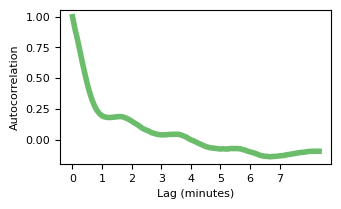

In [145]:
dir = "../movies-Pak1-GFP/2024_07_08-PolProbeMovies/1patch/"
wt_files = readdir(dir)
plot(ylabel="Correlation", xlabel="Lag (minutes)",
    legend=:bottomright, size=(600,400))
all_ac = zeros(101)
t_cor = range(0,100)*(5/60)
n = 0
for f in wt_files
    mask = mask_site("$dir$f", 0.5)
    max_patch = maximum(mask, dims=(1,2))[1,1,:]
    crop_max = crop_time(max_patch, 15*(60/5), 0.5)
    ac = crosscor(crop_max, crop_max, 0:100)
    all_ac += ac
    n+=1
    #plot!(t_cor, ac, x_ticks=0:8, alpha=0.1, label=false, linewidth=3)
end

fig, ax = subplots(figsize=(3.5,2))
ax.plot(t_cor, all_ac./n, color="C02", linewidth=4, alpha=0.7)
ax.set_ylabel("Autocorrelation", fontsize=8)
ax.set_xlabel("Lag (minutes)", fontsize=8)
ax.tick_params(labelsize=8)
ax.set_xticks([0,1,2,3,4,5,6,7])

savefig("../figures/ac_avg.svg")
display(gcf())


In [54]:
dir = "../movies-Pak1-GFP/2024_07_08-PolProbeMovies/1patch/"
wt_files = readdir(dir)
max_powers = zeros(95)
n=0

t_cor = range(0,100)*(5/60)

for f in wt_files
    mask = mask_site("$dir$f")
    max_patch = maximum(mask, dims=(1,2))[1,1,:]
    crop_max = crop_time(max_patch, 15*(60/5), 0.5)
    t = range(1,length(crop_max))*(5/60)

    cell = replace(f,".tif" => "")

    pdg_max = DSP.Periodograms.periodogram(crop_max)
    max_powers = max_powers .+ pdg_max.power
    frequencies = pdg_max.freq

    ac = crosscor(crop_max, crop_max, 0:100)

    n+=1

    plot(ylabel="Fluoresence", xlabel="Time (minutes)", xticks=0:1:15,
    legend=:bottomright, size=(800,200), margin=5Plots.mm)
    plot!(t, crop_max, linewidth=2, label=false, xticks=0:1:15, dpi=600)
    savefig("../figures/traces/$cell.png")

    plot(ylabel="Power / frequency", xlabel="Period (minutes)",
        legend=:bottomright, size=(300,200), margin=5Plots.mm)
    plot!(1 ./ frequencies[3:end] .* (5/60), pdg_max.power[3:end], xflip = false, label=false, linewidth=2, dpi=600)
    savefig("../figures/periodograms/$cell.png")

    plot(ylabel="Correlation", xlabel="Lag (minutes)",
        legend=:bottomright, size=(300,200), margin=5Plots.mm)
    plot!(t_cor, ac, x_ticks=0:8, linewidth=2, dpi=600, label=false)
    savefig("../figures/autocorr/$cell.png")
end

..........

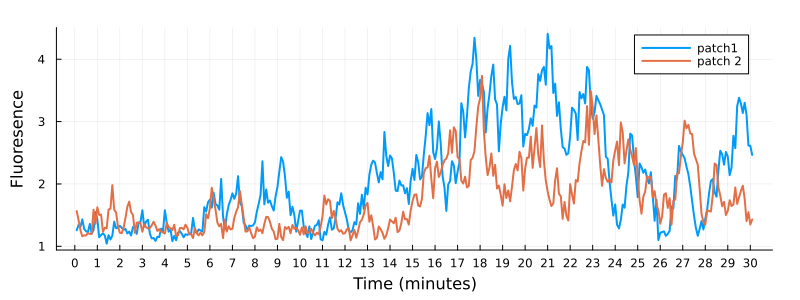

In [278]:
file = "../movies-Pak1-GFP/2024_07_08-PolProbeMovies/2patch/movie2-cell4.tif"
patches = mask_site(file, n_sites=2)
patch1 = patches[:,:,:,1]
patch2 = patches[:,:,:,2]
max_patch1 = maximum(patch1, dims=(1,2))[1,1,:]
max_patch2 = maximum(patch2, dims=(1,2))[1,1,:]
#crop_max1 = crop_time(max_patch1, 15*(60/5), 0.5)
#crop_max2 = crop_time(max_patch2, 15*(60/5), 0.5)
#t = range(1,length(crop_max))*(5/60) # Convert from 1 frame every 5 sec, to minutes
t = range(1,length(max_patch1))*(5/60)
plot(t, max_patch1, linewidth=2, label="patch1", xlabel="Time (minutes)", 
    ylabel="Fluoresence", size=(800,300), margin=5Plots.mm, xticks=0:1:30)
plot!(t, max_patch2,label="patch 2", linewidth=2, color=2)

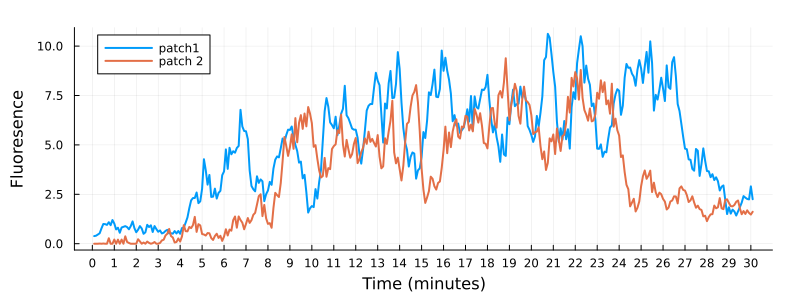

In [341]:
file = "../movies-Pak1-GFP/2024_07_08-PolProbeMovies/2patch/movie2-cell5.tif"
patches = mask_site(file, n_sites=2)
patch1 = patches[:,:,:,1]
patch2 = patches[:,:,:,2]
max_patch1 = maximum(patch1, dims=(1,2))[1,1,:]
max_patch2 = maximum(patch2, dims=(1,2))[1,1,:]
#crop_max1 = crop_time(max_patch1, 15*(60/5), 0.5)
#crop_max2 = crop_time(max_patch2, 15*(60/5), 0.5)
#t = range(1,length(crop_max))*(5/60) # Convert from 1 frame every 5 sec, to minutes
t = range(1,length(max_patch1))*(5/60)
plot(t, max_patch1, linewidth=2, label="patch1", xlabel="Time (minutes)", 
    ylabel="Fluoresence", size=(800,300), margin=5Plots.mm, xticks=0:1:30)
plot!(t, max_patch2,label="patch 2", linewidth=2, color=2)

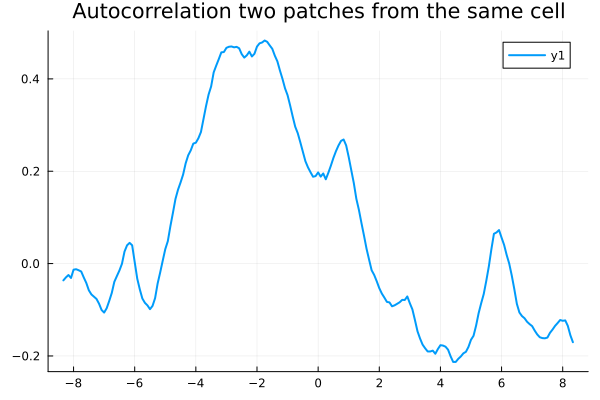

In [346]:
start = Int(8*(60/5))
xcor = crosscor(max_patch1[start:end], max_patch2[start:end], -100:100)
tcor = range(-100,100)*(5/60)
plot(tcor,xcor, xticks=-8:2:8, linewidth=2, title="Autocorrelation two patches from the same cell")

.

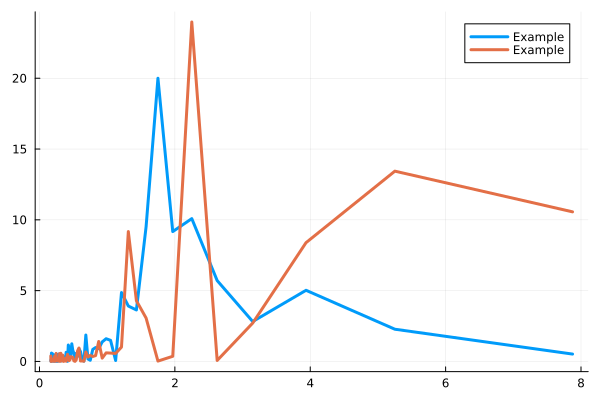

In [251]:
file = "../movies-Pak1-GFP/2024_07_08-PolProbeMovies/2patch/movie2-cell4.tif"
patches = mask_site(file, n_sites=2)
patch1 = patches[:,:,:,1]
patch2 = patches[:,:,:,2]
max_patch1 = maximum(patch1, dims=(1,2))[1,1,:]
max_patch2 = maximum(patch2, dims=(1,2))[1,1,:]
crop_max1 = crop_time(max_patch1, 15*(60/5), 0.5)
crop_max2 = crop_time(max_patch2, 15*(60/5), 0.5)
pdg_crop_max1 = DSP.Periodograms.periodogram(crop_max1)
pdg_crop_max2 = DSP.Periodograms.periodogram(crop_max2)
plot(1 ./ frequencies[3:end] .* (5/60), pdg_crop_max1.power[3:end], xflip = false, label="Example", linewidth=3, alpha=1, color=1)
plot!(1 ./ frequencies[3:end] .* (5/60), pdg_crop_max2.power[3:end], xflip = false, label="Example", linewidth=3, alpha=1, color=2)

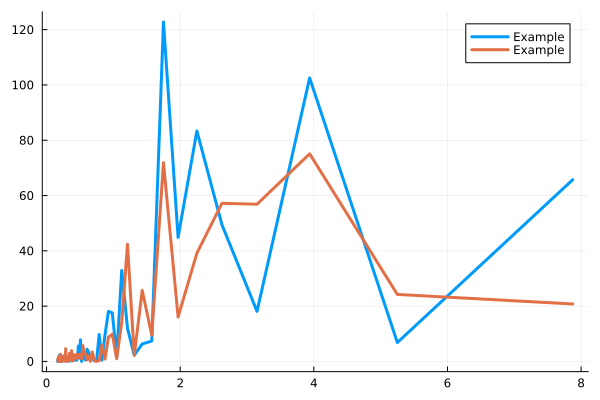

In [252]:
file = "../movies-Pak1-GFP/2024_07_08-PolProbeMovies/2patch/movie2-cell5.tif"
patches = mask_site(file, n_sites=2)
patch1 = patches[:,:,:,1]
patch2 = patches[:,:,:,2]
max_patch1 = maximum(patch1, dims=(1,2))[1,1,:]
max_patch2 = maximum(patch2, dims=(1,2))[1,1,:]
crop_max1 = crop_time(max_patch1, 15*(60/5), 0.5)
crop_max2 = crop_time(max_patch2, 15*(60/5), 0.5)
pdg_crop_max1 = DSP.Periodograms.periodogram(crop_max1)
pdg_crop_max2 = DSP.Periodograms.periodogram(crop_max2)
plot(1 ./ frequencies[3:end] .* (5/60), pdg_crop_max1.power[3:end], xflip = false, label="Example", linewidth=3, alpha=1, color=1)
plot!(1 ./ frequencies[3:end] .* (5/60), pdg_crop_max2.power[3:end], xflip = false, label="Example", linewidth=3, alpha=1, color=2)

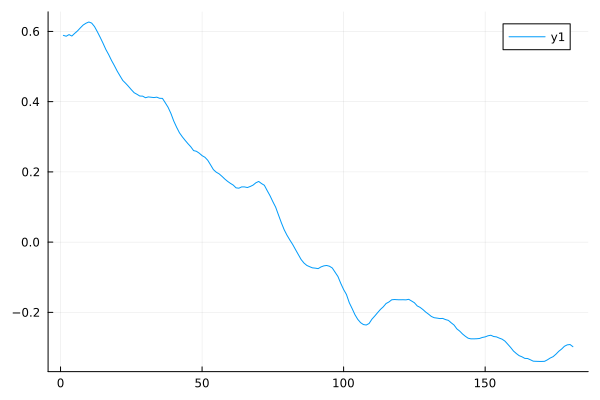

In [270]:
plot(crosscor(max_patch1, max_patch2, 0:1:180))

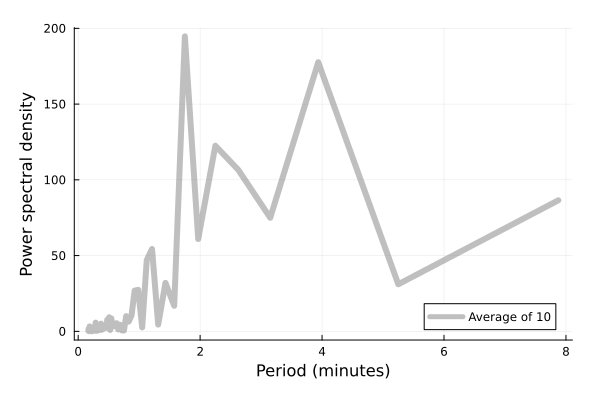

In [255]:
dir = "../movies-Pak1-GFP/2024_07_08-PolProbeMovies/2patch/"
wt_files = readdir(dir)
plot(ylabel="Power spectral density", xlabel="Period (minutes)",
    legend=:bottomright, size=(600,400))
t = range(0,60/5*30)*(5/60) # Convert from 1 frame every 5 sec, to minutes
max_powers = zeros(95)
n=0
frequencies = 0
for f in wt_files
    patches = mask_site("$dir$f", n_sites=2)
    patch1 = patches[:,:,:,1]
    patch2 = patches[:,:,:,2]
    crop_max1 = crop_time(max_patch1, 15*(60/5), 0.5)
    crop_max2 = crop_time(max_patch2, 15*(60/5), 0.5)
    pdg_max1 = DSP.Periodograms.periodogram(crop_max1)
    pdg_max2 = DSP.Periodograms.periodogram(crop_max2)
    max_powers = max_powers .+ pdg_max1.power
    max_powers = max_powers .+ pdg_max2.power
    frequencies = pdg_max1.freq

    n+=1
    #plot!(1 ./ frequencies[3:end] .* (5/60), pdg_max.power[3:end], xflip = true, label=false, linewidth=1, alpha=0.2)
end
plot!(1 ./ frequencies[3:end] .* (5/60), max_powers[3:end]/n, xflip = false, label="Average of $(length(wt_files))", linewidth=6, alpha=0.5, margin=5Plots.mm, color="grey")
#savefig("../figures/Pak1GFP_periodogram_withExample.png")

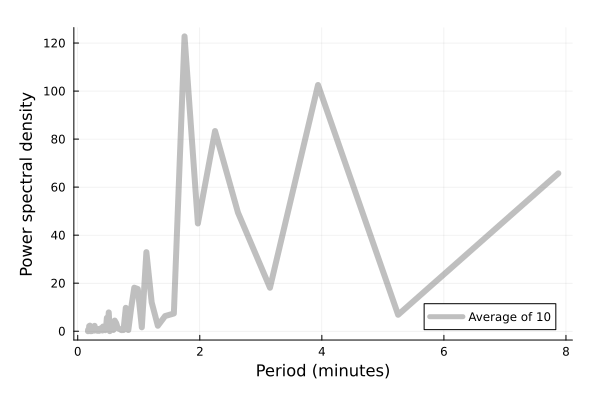

In [256]:
dir = "../movies-Pak1-GFP/2024_07_08-PolProbeMovies/2patch/"
wt_files = readdir(dir)
plot(ylabel="Power spectral density", xlabel="Period (minutes)",
    legend=:bottomright, size=(600,400))
t = range(0,60/5*30)*(5/60) # Convert from 1 frame every 5 sec, to minutes
max_powers = zeros(95)
n=0
frequencies = 0
for f in wt_files
    patches = mask_site("$dir$f", n_sites=2)
    patch1 = patches[:,:,:,1]
    patch2 = patches[:,:,:,2]
    crop_max1 = crop_time(max_patch1, 15*(60/5), 0.5)
    crop_max2 = crop_time(max_patch2, 15*(60/5), 0.5)
    pdg_max1 = DSP.Periodograms.periodogram(crop_max1)
    pdg_max2 = DSP.Periodograms.periodogram(crop_max2)
    max_powers = max_powers .+ pdg_max1.power
    #max_powers = max_powers .+ pdg_max2.power
    frequencies = pdg_max1.freq

    n+=1
    #plot!(1 ./ frequencies[3:end] .* (5/60), pdg_max.power[3:end], xflip = true, label=false, linewidth=1, alpha=0.2)
end
plot!(1 ./ frequencies[3:end] .* (5/60), max_powers[3:end]/n, xflip = false, label="Average of $(length(wt_files))", linewidth=6, alpha=0.5, margin=5Plots.mm, color="grey")
#savefig("../figures/Pak1GFP_periodogram_withExample.png")

In [96]:
pdg_max = DSP.Periodograms.periodogram((max_patch.-mean(max_patch))*12)
pdg_crop_max = DSP.Periodograms.periodogram((crop_max.-mean(crop_max))*12)
pdg_sum = DSP.Periodograms.periodogram(sum_patch.-mean(sum_patch))
pdg_crop_sum = DSP.Periodograms.periodogram(crop_sum.-mean(crop_sum))

DSP.Periodograms.Periodogram{Float64, AbstractFFTs.Frequencies{Float64}, Vector{Float64}}([1.830087566552065e-27, 10875.026524950641, 4943.858414961338, 3306.430910860453, 4440.029366689776, 4109.482803651683, 7194.762799069995, 5728.318313294417, 6121.902727853693, 640.9836748162195  …  1.486322595432567, 6.265363800340456, 5.063231876778332, 18.65563019753582, 31.431508729612666, 10.757725786022315, 4.717995726907722, 2.5973167092808946, 22.41325146819478, 8.249397851033445], [0.0, 0.005291005291005291, 0.010582010582010581, 0.015873015873015872, 0.021164021164021163, 0.026455026455026454, 0.031746031746031744, 0.037037037037037035, 0.042328042328042326, 0.047619047619047616  …  0.4497354497354497, 0.455026455026455, 0.4603174603174603, 0.4656084656084656, 0.4708994708994709, 0.47619047619047616, 0.48148148148148145, 0.48677248677248675, 0.49206349206349204, 0.4973544973544973])

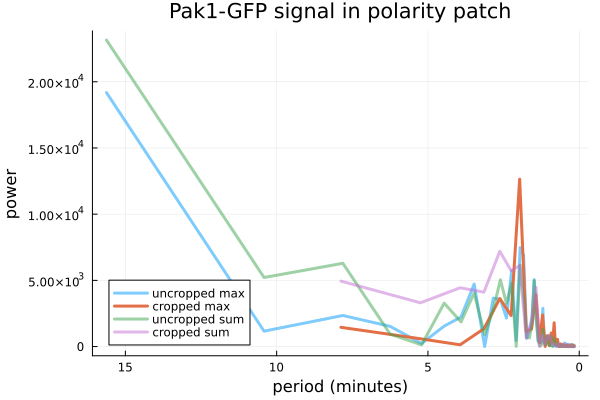

In [97]:
plot(label="WT", ylabel="power", xlabel="period (minutes)", title="Pak1-GFP signal in polarity patch")
plot(1 ./ pdg_max.freq[3:end] .* (5/60), pdg_max.power[3:end], xflip = true, label="uncropped max", linewidth=3, alpha=0.5, title="Power spectrum of signal at poalrity patch")
plot!(1 ./ pdg_crop_max.freq[3:end] .* (5/60), pdg_crop_max.power[3:end], xflip = true, label="cropped max", linewidth=3, alpha=1, title="Power spectrum of signal at poalrity patch")
plot!(1 ./ pdg_sum.freq[3:end] .* (5/60), pdg_sum.power[3:end], xflip = true, label="uncropped sum", linewidth=3, alpha=0.5, title="Power spectrum of signal at poalrity patch")
plot!(1 ./ pdg_crop_sum.freq[3:end] .* (5/60), pdg_crop_sum.power[3:end], xflip = true, label="cropped sum", linewidth=3, alpha=0.5, title="Power spectrum of signal at poalrity patch",legend=:bottomleft)
plot!(ylabel="power", xlabel="period (minutes)", title="Pak1-GFP signal in polarity patch")

In [98]:
periods = 1 ./ pdg_crop_max.freq .* (5/60)
per_mask = periods .< 5
where_max = findmax(pdg_crop_max.power .* per_mask)[2]
periods[where_max]

1.96875

In [99]:
pdg_max = DSP.Periodograms.periodogram((max_patch)*12)
pdg_crop_max = DSP.Periodograms.periodogram((crop_max)*12)
pdg_sum = DSP.Periodograms.periodogram(sum_patch)
pdg_crop_sum = DSP.Periodograms.periodogram(crop_sum)

DSP.Periodograms.Periodogram{Float64, AbstractFFTs.Frequencies{Float64}, Vector{Float64}}([595466.2053162549, 12175.742676978673, 628.2699671468145, 5340.9203188419, 12079.6030342831, 1701.512352207012, 16338.734948488822, 1519.9510511074504, 1577.498195789566, 2876.9562539925128  …  44.93257829506301, 63.45889804361023, 53.95692411043988, 78.42748632271453, 34.6656352917704, 14.401757192104663, 23.60202467912534, 11.064992226136571, 17.038224421231707, 6.129019180005327], [0.0, 0.005291005291005291, 0.010582010582010581, 0.015873015873015872, 0.021164021164021163, 0.026455026455026454, 0.031746031746031744, 0.037037037037037035, 0.042328042328042326, 0.047619047619047616  …  0.4497354497354497, 0.455026455026455, 0.4603174603174603, 0.4656084656084656, 0.4708994708994709, 0.47619047619047616, 0.48148148148148145, 0.48677248677248675, 0.49206349206349204, 0.4973544973544973])

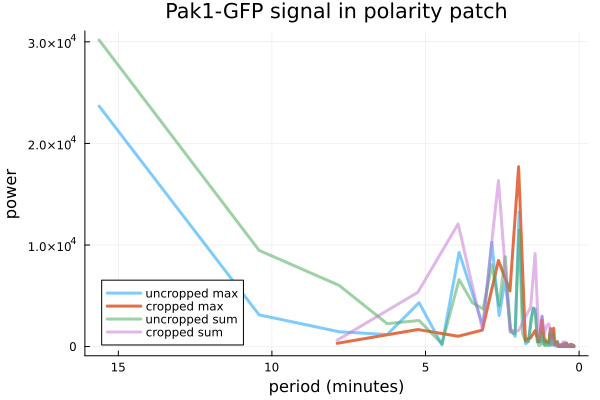

In [101]:
plot(1 ./ pdg_max.freq[3:end] .* (5/60), pdg_max.power[3:end], xflip = true, label="uncropped max", linewidth=3, alpha=0.5, title="Power spectrum of signal at poalrity patch")
plot!(1 ./ pdg_crop_max.freq[3:end] .* (5/60), pdg_crop_max.power[3:end], xflip = true, label="cropped max", linewidth=3, alpha=1, title="Power spectrum of signal at poalrity patch")
plot!(1 ./ pdg_sum.freq[3:end] .* (5/60), pdg_sum.power[3:end], xflip = true, label="uncropped sum", linewidth=3, alpha=0.5, title="Power spectrum of signal at poalrity patch")
plot!(1 ./ pdg_crop_sum.freq[3:end] .* (5/60), pdg_crop_sum.power[3:end], xflip = true, label="cropped sum", linewidth=3, alpha=0.5, title="Power spectrum of signal at poalrity patch")
plot!(ylabel="power", xlabel="period (minutes)", title="Pak1-GFP signal in polarity patch", legend=:bottomleft)

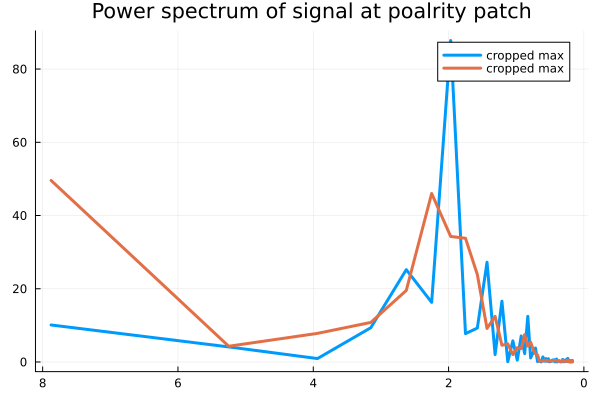

In [102]:
crop_max = crop_time(max_patch, 15*(60/5), 0.5)
s = crop_max.-mean(crop_max)
pdg_crop_max_og = DSP.Periodograms.periodogram(s)
pdg_crop_max2 = DSP.Periodograms.mt_pgram((crop_max.-mean(crop_max)), nw=2)
plot(1 ./ pdg_crop_max_og.freq[3:end] .* (5/60), pdg_crop_max_og.power[3:end], xflip = true, label="cropped max", linewidth=3, alpha=1, title="Power spectrum of signal at poalrity patch")
#plot!(1 ./ pdg_crop_max.freq[3:end] .* (5/60), pdg_crop_max.power[3:end], xflip = true, label="cropped max", linewidth=3, alpha=1, title="Power spectrum of signal at poalrity patch")
plot!(1 ./ pdg_crop_max2.freq[3:end] .* (5/60), pdg_crop_max2.power[3:end], xflip = true, label="cropped max", linewidth=3, alpha=1, title="Power spectrum of signal at poalrity patch")

.............................

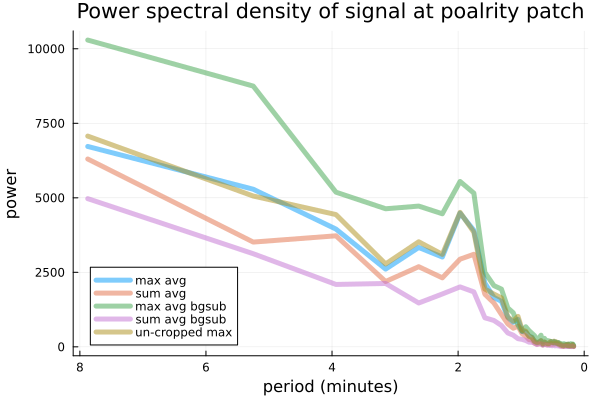

In [157]:
dir = "../movies-Pak1-GFP/2024_07_08-PolProbeMovies/1patch/"
wt_files = readdir(dir)
plot(ylabel="power", xlabel="period (minutes)", title="Power spectral density of signal at poalrity patch" ,legend=:bottomleft)
t = range(0,60/5*30)*(5/60) # Convert from 1 frame every 5 sec, to minutes
max_powers = zeros(95)
sum_powers = zeros(95)
max_powers2 = zeros(95)
sum_powers2 = zeros(95)
ucm_powers = zeros(95)
n=0
frequencies = 0
for f in wt_files
    mask = mask_site("$dir$f")
    max_patch = maximum(mask, dims=(1,2))[1,1,:]
    sum_patch = sum(mask, dims=(1,2))[1,1,:]
    crop_max = crop_time(max_patch, 15*(60/5), 0.5)
    crop_sum = crop_time(sum_patch, 15*(60/5), 0.5)
    pdg_sum = DSP.Periodograms.periodogram(crop_sum)
    pdg_max = DSP.Periodograms.periodogram(crop_max)
    max_powers = max_powers .+ pdg_max.power
    sum_powers = sum_powers .+ pdg_sum.power
    pdg_sum2 = DSP.Periodograms.periodogram(crop_sum.-mean(crop_sum))
    pdg_max2 = DSP.Periodograms.periodogram(crop_max.-mean(crop_max))
    max_powers2 = max_powers2 .+ pdg_max2.power
    sum_powers2 = sum_powers2 .+ pdg_sum2.power
    img = load("$dir$f")
    im_array = Float64.(img)
    frame_avg = mean(im_array, dims=(1,2))
    im_array = im_array ./ frame_avg
    im_array = im_array .- mean(im_array)
    ucm = maximum(im_array, dims=(1,2))[1,1,:]
    crop_ucm = crop_time(ucm, 15*(60/5), 0.5)
    pdg_ucm = DSP.Periodograms.periodogram(crop_ucm)
    ucm_powers = ucm_powers .+ pdg_ucm.power
    frequencies = pdg_sum.freq
    n+=1
end
plot!(1 ./ frequencies[3:end] .* (5/60), max_powers[3:end]*2, xflip = true, label="max avg", linewidth=5, alpha=0.5)
plot!(1 ./ frequencies[3:end] .* (5/60), sum_powers[3:end]/n, xflip = true, label="sum avg", linewidth=5, alpha = 0.5)
plot!(1 ./ frequencies[3:end] .* (5/60), max_powers2[3:end]*4, xflip = true, label="max avg bgsub", linewidth=5, alpha = 0.5)
plot!(1 ./ frequencies[3:end] .* (5/60), sum_powers2[3:end]/n, xflip = true, label="sum avg bgsub", linewidth=5, alpha = 0.5)
plot!(1 ./ frequencies[3:end] .* (5/60), ucm_powers[3:end]*2, xflip = true, label="un-cropped max", linewidth=5, alpha = 0.5)
#savefig("wt_periods.png")

0.5
.........plot0.6
............plot0.7
.............plot0.8
...............plot

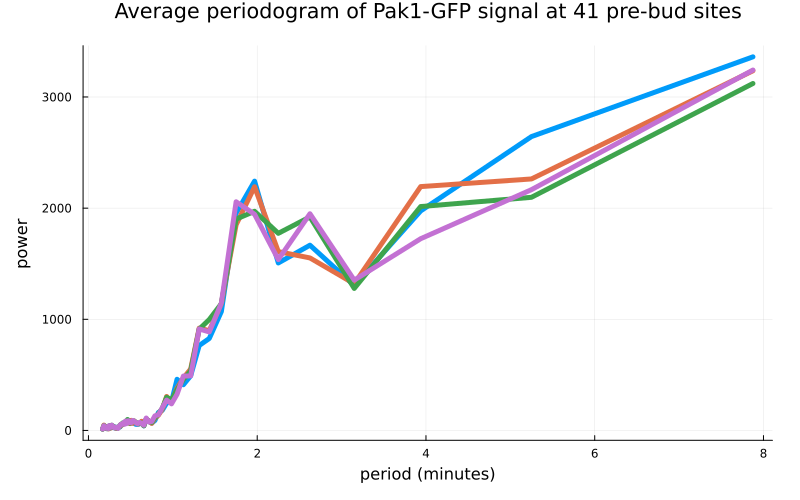

In [155]:
dir = "../movies-Pak1-GFP/2024_07_08-PolProbeMovies/1patch/"
wt_files = readdir(dir)
plot(ylabel="power", xlabel="period (minutes)", title="Average periodogram of Pak1-GFP signal at $(length(wt_files)) pre-bud sites",
    legend=:bottomleft, size=(800,500))
t = range(0,60/5*30)*(5/60) # Convert from 1 frame every 5 sec, to minutes
for i in [0.5,0.6,0.7,0.8]
    println(i)
    max_powers = zeros(95)
    n=0
    frequencies = 0
    for f in wt_files
        mask = mask_site("$dir$f")
        max_patch = maximum(mask, dims=(1,2))[1,1,:]
        crop_max = crop_time(max_patch, 15*(60/5), i)
        pdg_max = DSP.Periodograms.periodogram(crop_max)
        max_powers = max_powers .+ pdg_max.power
        frequencies = pdg_max.freq
        n+=1
        #plot!(1 ./ frequencies[3:end] .* (5/60), pdg_max.power[3:end], xflip = true, label=false, linewidth=1, alpha=0.2)
    end
    print("plot")
    plot!(1 ./ frequencies[3:end] .* (5/60), max_powers[3:end], xflip = false, label=false, linewidth=5, alpha=1, margin=5Plots.mm)
end
#savefig("../figures/Pak1GFP_periodogram.png")
plot!()

.............................

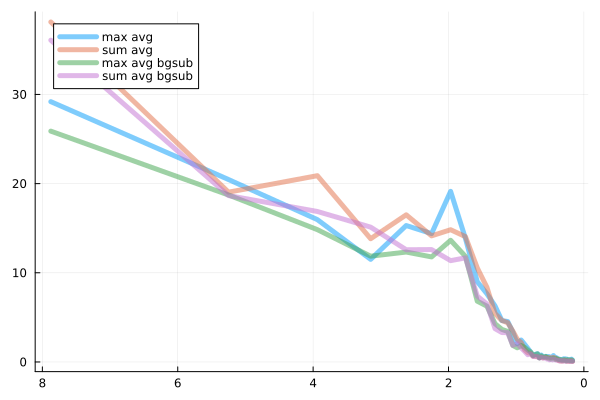

In [12]:
dir = "../movies-Pak1-GFP/2024_07_08-PolProbeMovies/1patch/"
wt_files = readdir(dir)
plot(ylabel="power", xlabel="period (minutes)", title="Normalized power spectral density of signal at poalrity patch" ,legend=:bottomleft)
t = range(0,60/5*30)*(5/60) # Convert from 1 frame every 5 sec, to minutes
max_powers = zeros(95)
sum_powers = zeros(95)
max_powers2 = zeros(95)
sum_powers2 = zeros(95)
ucm_powers = zeros(95)
n=0
frequencies = 0
for f in wt_files
    mask = mask_site("$dir$f")
    max_patch = maximum(mask, dims=(1,2))[1,1,:]
    sum_patch = sum(mask, dims=(1,2))[1,1,:]
    crop_max = crop_time(max_patch, 15*(60/5), 0.5)
    crop_sum = crop_time(sum_patch, 15*(60/5), 0.5)
    crop_max = (crop_max.-minimum(crop_max))./maximum(crop_max)
    crop_sum = (crop_sum.-minimum(crop_sum))./maximum(crop_sum)
    pdg_sum = DSP.Periodograms.periodogram(crop_sum)
    pdg_max = DSP.Periodograms.periodogram(crop_max)
    max_powers = max_powers .+ pdg_max.power
    sum_powers = sum_powers .+ pdg_sum.power
    pdg_sum2 = DSP.Periodograms.periodogram(crop_sum.-mean(crop_sum))
    pdg_max2 = DSP.Periodograms.periodogram(crop_max.-mean(crop_max))
    max_powers2 = max_powers2 .+ pdg_max2.power
    sum_powers2 = sum_powers2 .+ pdg_sum2.power
    img = load("$dir$f")
    im_array = Float64.(img)
    frame_avg = mean(im_array, dims=(1,2))
    im_array = im_array ./ frame_avg
    im_array = im_array .- mean(im_array)
    ucm = maximum(im_array, dims=(1,2))[1,1,:]
    crop_ucm = crop_time(ucm, 15*(60/5), 0.5)
    pdg_ucm = DSP.Periodograms.periodogram(crop_ucm)
    ucm_powers = ucm_powers .+ pdg_ucm.power
    frequencies = pdg_sum.freq
    n+=1
end
plot(1 ./ frequencies[3:end] .* (5/60), max_powers[3:end], xflip = true, label="max avg", linewidth=5, alpha=0.5)
plot!(1 ./ frequencies[3:end] .* (5/60), sum_powers[3:end], xflip = true, label="sum avg", linewidth=5, alpha = 0.5)
plot!(1 ./ frequencies[3:end] .* (5/60), max_powers2[3:end], xflip = true, label="max avg bgsub", linewidth=5, alpha = 0.5)
plot!(1 ./ frequencies[3:end] .* (5/60), sum_powers2[3:end], xflip = true, label="sum avg bgsub", linewidth=5, alpha = 0.5)
#savefig("wt_periods.png")

In [189]:
dir = "../movies-Pak1-GFP/2024_07_08-PolProbeMovies/1patch/"
wt_files = readdir(dir)
plot(ylabel="Power spectral density", xlabel="Period (minutes)",
    legend=:bottomright, size=(600,400))
t = range(0,60/5*30)*(5/60) # Convert from 1 frame every 5 sec, to minutes
max_powers = zeros(95)
n=0
frequencies = 0
for f in wt_files
    mask = mask_site("$dir$f")
    max_patch = maximum(mask, dims=(1,2))[1,1,:]
    crop_max = crop_time(max_patch, 15*(60/5), 0.5)
    pdg_max = DSP.Periodograms.periodogram(crop_max)
    max_powers = max_powers .+ pdg_max.power
    frequencies = pdg_max.freq
    n+=1
    #plot!(1 ./ frequencies[3:end] .* (5/60), pdg_max.power[3:end], xflip = true, label=false, linewidth=1, alpha=0.2)
end
plot!(1 ./ frequencies[3:end] .* (5/60), max_powers[3:end]/n, xflip = false, label="Average of $(length(wt_files))", linewidth=6, alpha=0.5, ylim=(0,100), margin=5Plots.mm, color="grey")
file = "../movies-Pak1-GFP/2024_07_08-PolProbeMovies/1patch/movie2-cell9.tif"
patch = mask_site(file)
max_patch = maximum(patch, dims=(1,2))[1,1,:]
crop_max = crop_time(max_patch, 15*(60/5), 0.5)
pdg_crop_max = DSP.Periodograms.periodogram((crop_max.-mean(crop_max)))
plot!(1 ./ frequencies[3:end] .* (5/60), pdg_crop_max.power[3:end], xflip = false, label="Example", linewidth=3, alpha=1, ylim=(0,100), margin=5Plots.mm, color=1)
#savefig("../figures/Pak1GFP_periodogram_withExample.png")

.........

"/home/dinosaur/Lab/Polarity/proj/fig4-patchDynamics/figures/Pak1GFP_periodogram_withExample.png"

.............................

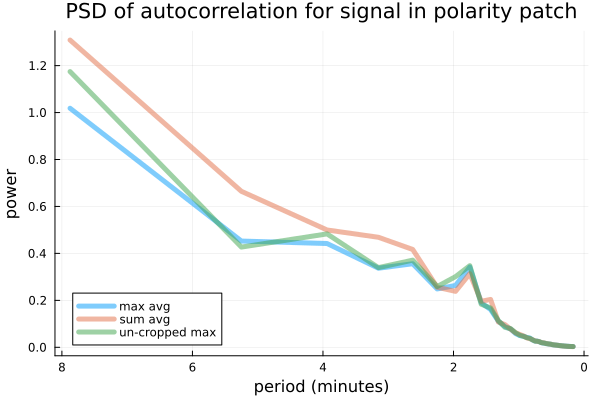

In [196]:
dir = "../movies-Pak1-GFP/2024_07_08-PolProbeMovies/1patch/"
wt_files = readdir(dir)
plot(label="WT", ylabel="power", xlabel="period (minutes)", title="PSD of autocorrelation for signal in polarity patch", legend=:bottomleft)
t = range(0,60/5*30)*(5/60) # Convert from 1 frame every 5 sec, to minutes
max_powers = zeros(95)
sum_powers = zeros(95)
max_powers2 = zeros(95)
sum_powers2 = zeros(95)
ucm_powers = zeros(95)
n=0
frequencies = 0
for f in wt_files
    mask = mask_site("$dir$f")
    max_patch = maximum(mask, dims=(1,2))[1,1,:]
    sum_patch = sum(mask, dims=(1,2))[1,1,:]
    crop_max = crop_time(max_patch, 15*(60/5), 0.5)
    crop_sum = crop_time(sum_patch, 15*(60/5), 0.5)
    ac_max = autocor(crop_max, range(0,length(crop_max)-1))
    ac_sum = autocor(crop_sum, range(0,length(crop_sum)-1))
    pdg_sum = DSP.Periodograms.periodogram(ac_sum)
    pdg_max = DSP.Periodograms.periodogram(ac_max)
    max_powers = max_powers .+ pdg_max.power
    sum_powers = sum_powers .+ pdg_sum.power
# Background subtraction does nothing when using autocorr.
    # ac_max2 = autocor(crop_max.-mean(crop_max), range(0,length(crop_max)-1))
    # ac_sum2 = autocor(crop_sum.-mean(crop_max), range(0,length(crop_sum)-1))
    # pdg_sum2 = DSP.Periodograms.periodogram(ac_sum2)
    # pdg_max2 = DSP.Periodograms.periodogram(ac_max2)
    # max_powers2 = max_powers2 .+ pdg_max2.power
    # sum_powers2 = sum_powers2 .+ pdg_sum2.power
    img = load("$dir$f")
    im_array = Float64.(img)
    frame_avg = mean(im_array, dims=(1,2))
    im_array = im_array ./ frame_avg
    im_array = im_array .- mean(im_array)
    ucm = maximum(im_array, dims=(1,2))[1,1,:]
    crop_ucm = crop_time(ucm, 15*(60/5), 0.5)
    ac_ucm = autocor(crop_ucm, range(0,length(crop_ucm)-1))
    pdg_ucm = DSP.Periodograms.periodogram(ac_ucm)
    ucm_powers = ucm_powers .+ pdg_ucm.power
    frequencies = pdg_sum.freq
    n+=1
end
plot!(1 ./ frequencies[3:end] .* (5/60), max_powers[3:end]/n, xflip = true, label="max avg", linewidth=5, alpha=0.5)
plot!(1 ./ frequencies[3:end] .* (5/60), sum_powers[3:end]/n, xflip = true, label="sum avg", linewidth=5, alpha = 0.5)
#plot!(1 ./ frequencies[3:end] .* (5/60), max_powers2[3:end]/n, xflip = true, label="max avg bgsub", linewidth=5, alpha = 0.5)
#plot!(1 ./ frequencies[3:end] .* (5/60), sum_powers2[3:end]/n, xflip = true, label="sum avg bgsub", linewidth=5, alpha = 0.5)
plot!(1 ./ frequencies[3:end] .* (5/60), ucm_powers[3:end]/n, xflip = true, label="un-cropped max", linewidth=5, alpha = 0.5)
#savefig("wt_periods.png")

...................

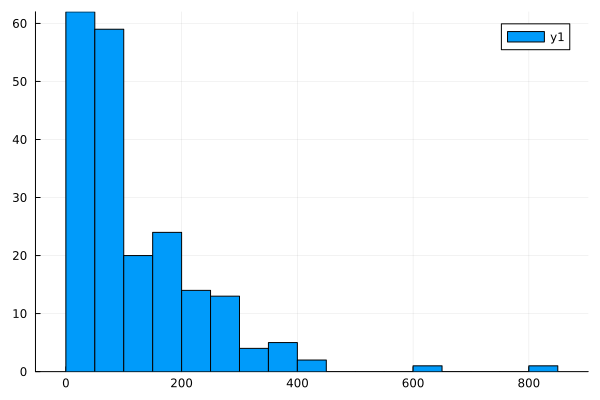

In [129]:
dir = "../movies-Pak1-GFP/2024_07_08-PolProbeMovies/1patch/"
wt_files = readdir(dir)
plot(label="WT", ylabel="power", xlabel="period (minutes)", title="PSD of autocorrelation for signal in polarity patch", legend=:bottomleft)
t = range(0,60/5*30)*(5/60) # Convert from 1 frame every 5 sec, to minutes
max_powers = zeros(95)
sum_powers = zeros(95)
max_powers2 = zeros(95)
sum_powers2 = zeros(95)

n=0
max_cov = zeros(5)
sum_cov = zeros(5)
all_max = zeros(5*length(wt_files))
for f in wt_files
    mask = mask_site("$dir$f")
    max_patch = maximum(mask, dims=(1,2))[1,1,:]
    sum_patch = sum(mask, dims=(1,2))[1,1,:]
    crop_max = crop_time(max_patch, 15*(60/5), 0.5)
    crop_sum = crop_time(sum_patch, 15*(60/5), 0.5)
    for win in range(1, 5)
        max_cov[win] = cov(crop_max[win*36-35 : win*36-1] .- mean(crop_max[win*36-35 : win*36-1])*10)
        sum_cov[win] = cov(crop_sum[win*36-35 : win*36-1] .- mean(crop_sum[win*36-35 : win*36-1]))
    end
    #scatter!(ones(15)*n, [max_cov], color=1, alpha=0.3)
    #scatter!(ones(15)*n, [sum_cov], color=2, alpha=0.3)
    all_max[n*5+1:n*5+5] = sum_cov
    n+=1
end
histogram(all_max)

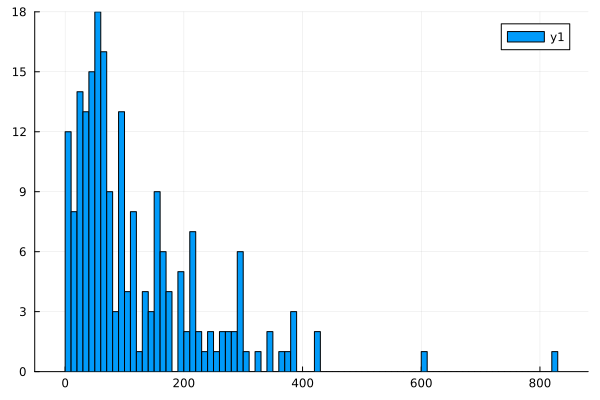

In [131]:
histogram(all_max, bins=100)

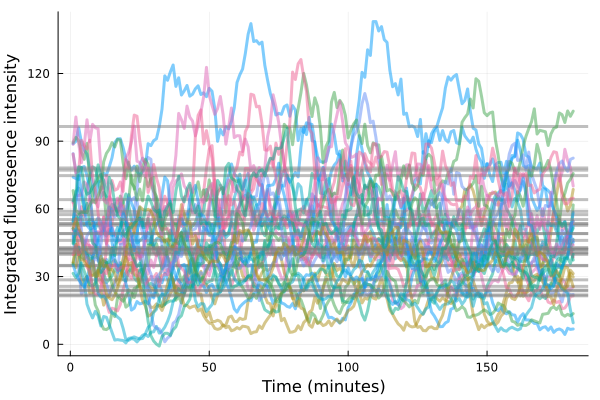

In [25]:
dir = "../movies-Pak1-GFP/2024_07_08-PolProbeMovies/1patch/"
wt_files = readdir(dir)
plot(label="WT", xlabel="Time (minutes)", ylabel="Integrated fluoresence intensity")
t = range(0,60/5*30)*(5/60) # Convert from 1 frame every 5 sec, to minutes
for f in wt_files
    mask = mask_site("$(dir)$(f)")
    mask_sum = sum(mask, dims=(1,2))[1,1,:]
    #plot!(t, mask_sum, linewidth=1, label=f)
    thresh = 0.6
    start = Integer(findall(mask_sum .> (maximum(mask_sum) + minimum(mask_sum))*thresh)[1])
    if start + 15*(60/5) < 361
        #window_t = range(start*5/60, start*5/60 + 15, step=5/60)
        plot!(mask_sum[start:start+Integer(60/5*15)], linewidth=3, alpha=0.5, label=false)
        hline!([mean(mask_sum[start:start+Integer(60/5*15)])], linewidth=3, alpha=0.5, color="grey", label=false)
    end
end
plot!()
#savefig("wt_signals.png")

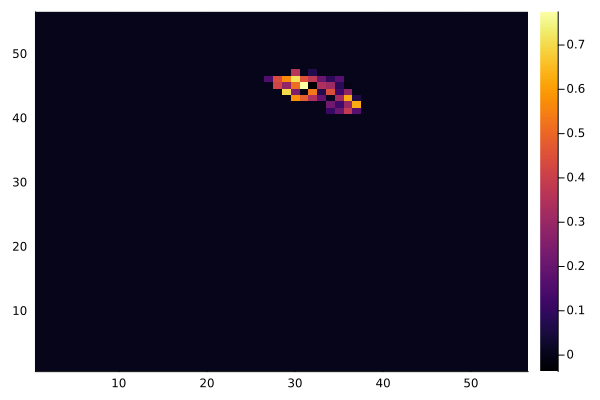

In [301]:
heatmap(mask[:,:,Integer(8*(60/5)),1])